# Final Project-The Battle of Neighborhoods - Look for a nice resident in Downtown Toronto

### Importing and Installing required Libraries

In [1]:
!pip install geocoder
!pip install folium

In [2]:
import numpy as np
import requests
import pandas as pd
import geocoder
import folium
import requests 
import json
import xml
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import warnings
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

#Suppression warinings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Importing and Installing required Libraries completed")

Importing and Installing required Libraries completed


### Data Extraction and Data Cleansing

Data Source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

Have Scrapped Postal Codes data using BeautifulSoup. And converted PostalCode from HTML table and stored in dataframe

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
postcode_data = BeautifulSoup(extracting_data, 'lxml')

column_names = ['Postalcode','Borough','Neighborhood']
df_toronto = pd.DataFrame(columns = column_names)
content = postcode_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            borough = td.text.strip('\n')
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    df_toronto = df_toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

df_toronto = df_toronto[df_toronto.Borough!='Not assigned']
df_toronto = df_toronto[df_toronto.Borough!= 0]
df_toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,df_toronto.shape[0]):
    if df_toronto.iloc[i][2] == 'Not assigned':
        df_toronto.iloc[i][2] = df_toronto.iloc[i][1]
        i = i+1


df = df_toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]
df.head()

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


To fetch latitude and longitude for all Postal Codes

In [15]:
def merge_neighborhood(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(merge_neighborhood).reset_index(name='Neighborhood')

def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

# To append Latitude & Longitude 
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

#to test results
df_2[df_2.Postalcode == 'M5G']
df_2.head(10)

print('The latitude and longitude of Downtown Toronto are {}, {}.')

The latitude and longitude of Downtown Toronto are {}, {}.


In [20]:
geolocator = Nominatim()
location = geolocator.geocode('Downtown Toronto')
latitude_x = location.latitude
longitude_y = location.longitude
print('The latitude and longitude of Downtown Toronto are {}, {}.'.format(latitude_x, longitude_y))

The latitude and longitude of Downtown Toronto are 43.6541737, -79.38081164513409.


### Downtown Toronto Map

In [21]:
Downtown_Toronto_map = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Downtown_Toronto_map)  
    
Downtown_Toronto_map


Define Foursquare Credentials

In [29]:
CLIENT_ID = 'KLQZSDDREKW1NPNHJKJZ2UK00IGECV4SGHKWWFGQAOLDAWIY'
CLIENT_SECRET = 'LQOLRFAJ2SBSSYIXSP2BDQXCGSLDQKFBHFPEDTN2J45UY0BX' 
VERSION = '20191210'
LIMIT = 30

LIMIT = 100
radius = 700 
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

def fetch_category(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### To get nearby venues details

In [30]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()
nearby_venues['venue.categories'] = nearby_venues.apply(fetch_category, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
1,Elgin And Winter Garden Theatres,Theater,43.653394,-79.378507
2,Ed Mirvish Theatre,Theater,43.655102,-79.379768
3,Indigo,Bookstore,43.653515,-79.380696
4,LUSH,Cosmetics Shop,43.653557,-79.380400


In [33]:
#to fetch only Top 10 Categories

a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]



def get_Near_by_Venues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Downtown_Toronto_venues = get_Near_by_Venues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

#print('There are {} Uniques Categories.'.format(len(Downtown_Toronto_venues['Venue Category'].unique())))
Downtown_Toronto_venues.groupby('Neighborhood').count().head()


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,28,28,28,28,28,28
"Alderwood, Long Branch",12,12,12,12,12,12
"Bathurst Manor, Wilson Heights, Downsview North",25,25,25,25,25,25
Bayview Village,5,5,5,5,5,5
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25


### Using one hot encoding technique

In [35]:
Downtown_Toronto_onehot = pd.get_dummies(Downtown_Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# to add neighborhood column back to dataframe
Downtown_Toronto_onehot['Neighborhood'] = Downtown_Toronto_venues['Neighborhood'] 

# to move neighborhood column to Ist column
fixed_columns = [Downtown_Toronto_onehot.columns[-1]] + list(Downtown_Toronto_onehot.columns[:-1])
Downtown_Toronto_onehot = Downtown_Toronto_onehot[fixed_columns]
Downtown_Toronto_grouped = Downtown_Toronto_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5
for hood in Downtown_Toronto_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Downtown_Toronto_grouped[Downtown_Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
 


---- Agincourt ----
                      venue  freq
0        Chinese Restaurant  0.11
1             Shopping Mall  0.11
2                      Pool  0.04
3  Mediterranean Restaurant  0.04
4          Malay Restaurant  0.04


---- Alderwood, Long Branch ----
            venue  freq
0            Pool  0.08
1    Dance Studio  0.08
2  Sandwich Place  0.08
3     Coffee Shop  0.08
4    Skating Rink  0.08


---- Bathurst Manor, Wilson Heights, Downsview North ----
              venue  freq
0       Coffee Shop  0.08
1              Park  0.08
2              Bank  0.08
3    Sandwich Place  0.04
4  Sushi Restaurant  0.04


---- Bayview Village ----
                        venue  freq
0                        Park   0.6
1  Construction & Landscaping   0.2
2                       Trail   0.2
3                 Yoga Studio   0.0
4                Music School   0.0


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.08
1    Sushi Restaurant  0.08
2      

         venue  freq
0         Park  0.25
1   Playground  0.25
2         Café  0.25
3  Coffee Shop  0.25
4  Yoga Studio  0.00


---- Humewood-Cedarvale ----
               venue  freq
0      Grocery Store  0.14
1       Hockey Arena  0.14
2  Convenience Store  0.14
3     Soccer Stadium  0.14
4              Field  0.14


---- India Bazaar, The Beaches West ----
                  venue  freq
0  Fast Food Restaurant  0.06
1        Sandwich Place  0.06
2     Indian Restaurant  0.04
3                   Gym  0.04
4           Coffee Shop  0.04


---- Islington Avenue, Humber Valley Village ----
           venue  freq
0       Pharmacy  0.25
1           Bank  0.12
2           Café  0.12
3  Shopping Mall  0.12
4           Park  0.12


---- Kennedy Park, Ionview, East Birchmount Park ----
               venue  freq
0        Coffee Shop  0.20
1     Discount Store  0.20
2     Sandwich Place  0.07
3  Convenience Store  0.07
4         Hobby Shop  0.07


---- Kensington Market, Chinatown, Grange Park -

              venue  freq
0               Pub  0.08
1        Restaurant  0.08
2       Coffee Shop  0.08
3  Sushi Restaurant  0.08
4      Skating Rink  0.08


---- The Annex, North Midtown, Yorkville ----
                venue  freq
0                Café  0.09
1  Italian Restaurant  0.07
2      Sandwich Place  0.07
3         Coffee Shop  0.07
4      History Museum  0.05


---- The Beaches ----
               venue  freq
0                Pub  0.23
1        Coffee Shop  0.23
2          Gastropub  0.08
3  Health Food Store  0.08
4                Spa  0.08


---- The Danforth West, Riverdale ----
              venue  freq
0  Greek Restaurant  0.13
1              Café  0.10
2    Ice Cream Shop  0.06
3        Restaurant  0.06
4              Bank  0.06


---- The Kingsway, Montgomery Road, Old Mill North ----
                venue  freq
0  Italian Restaurant  0.11
1      Breakfast Spot  0.07
2    Sushi Restaurant  0.07
3                Bank  0.07
4   French Restaurant  0.04


---- Thorncliffe 

In [36]:
def fetch_mstcommonvenue(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
 
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
num_top_venues = 10
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Downtown_Toronto_grouped['Neighborhood']

for ind in np.arange(Downtown_Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = fetch_mstcommonvenue(Downtown_Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Pool Hall,Malay Restaurant,Lounge,Seafood Restaurant,Mediterranean Restaurant,Breakfast Spot,Latin American Restaurant,Sandwich Place
1,"Alderwood, Long Branch",Pizza Place,Pub,Gas Station,Dance Studio,Skating Rink,Athletics & Sports,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Park,Pharmacy,Diner,Sushi Restaurant,Fried Chicken Joint,Sandwich Place,Restaurant,Deli / Bodega
3,Bayview Village,Park,Construction & Landscaping,Trail,Women's Store,Electronics Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Sushi Restaurant,Restaurant,Coffee Shop,Pub,Butcher,Liquor Store,Café,Sports Club


#### Using K-Means to split nearby neighborhood into 3 clusters

In [37]:
Downtown_Toronto_grouped_clustering = Downtown_Toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Downtown_Toronto_grouped_clustering)
kmeans.labels_

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Downtown_Toronto_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Downtown_Toronto_merged = Downtown_Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Downtown_Toronto_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.808626,-79.189913,2,Park,Trail,Women's Store,Eastern European Restaurant,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.785779,-79.157368,0,Bar,History Museum,Park,Fish & Chips Shop,Convenience Store,Cosmetics Shop,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765806,-79.185284,1,Pizza Place,Bank,Grocery Store,Coffee Shop,Park,Restaurant,Fast Food Restaurant,Medical Center,Fried Chicken Joint,Intersection
3,M1G,Scarborough,Woburn,43.771545,-79.218135,1,Coffee Shop,Park,Business Service,Women's Store,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.768791,-79.238813,1,Bank,Thai Restaurant,Gas Station,Hakka Restaurant,Athletics & Sports,Eastern European Restaurant,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant


In [41]:
# Create Clusters Map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)
kclusters = 10
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Downtown_Toronto_merged['Latitude'], 
                                   Downtown_Toronto_merged['Longitude'], 
                                   Downtown_Toronto_merged['Neighborhood'], 
                                   Downtown_Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

df1=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 0,Downtown_Toronto_merged.columns[[2] + list(range(5, Downtown_Toronto_merged.shape[1]))]]
df2=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 1,Downtown_Toronto_merged.columns[[2] + list(range(5, Downtown_Toronto_merged.shape[1]))]]
df3=Downtown_Toronto_merged.loc[Downtown_Toronto_merged['Cluster Labels'] == 2,Downtown_Toronto_merged.columns[[2] + list(range(5, Downtown_Toronto_merged.shape[1]))]]



['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


#### School Ratings by Clusters in Downtown_Toronto

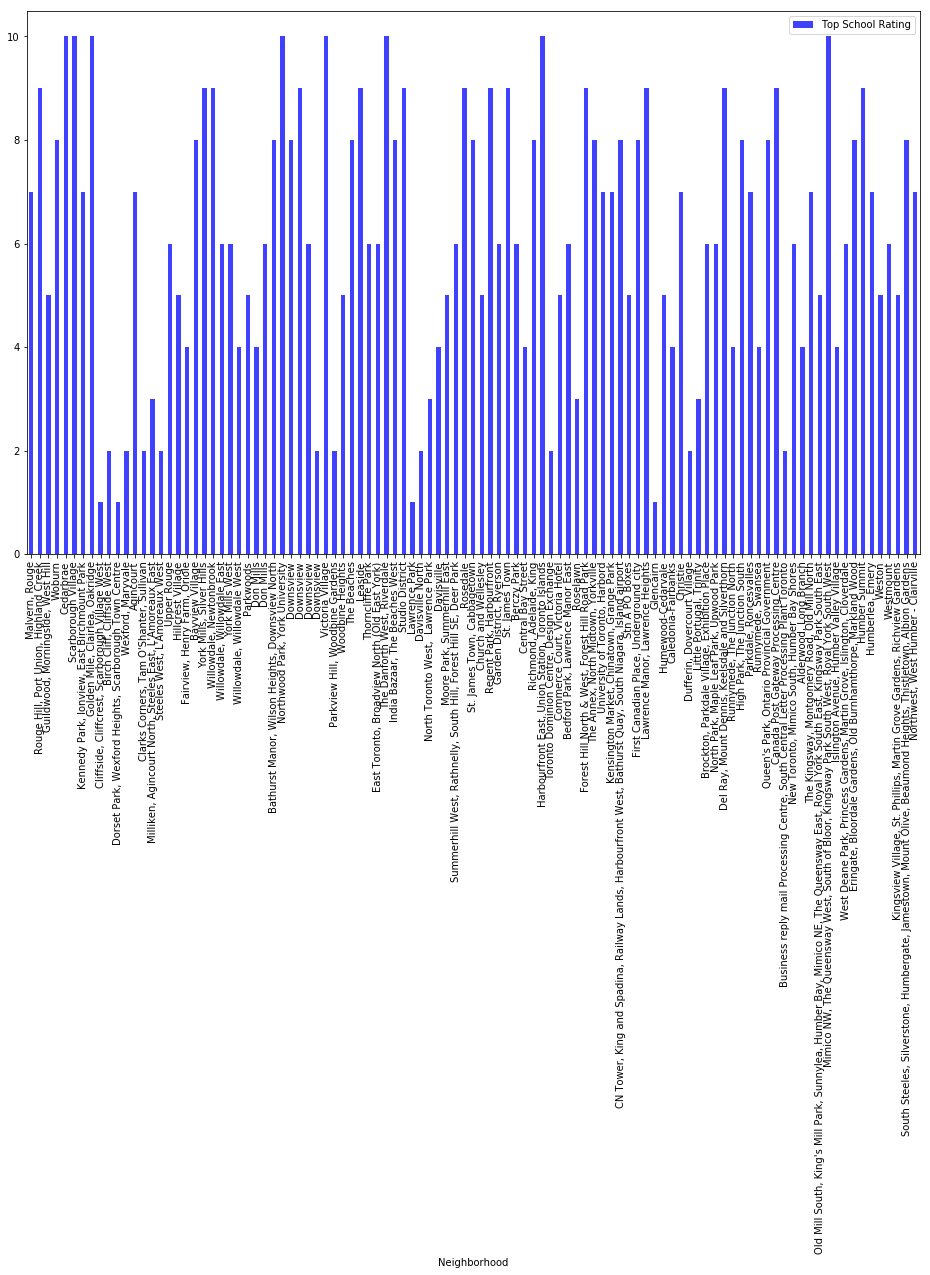

In [43]:
#fetched school ratings from:https://www.greatschools.org

clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)
new_Downtown_Toronto=Downtown_Toronto_merged.set_index("Neighborhood",drop=True)
Downtown_Toronto_ratingsschool=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})
 
Downtown_Toronto_ratingsschool.set_index('Neighborhood',inplace=True,drop=True)
Downtown_Toronto_ratingsschool.plot(kind='bar',figsize=(16,10),color='blue',alpha=0.75);

### Average Housing Price by Clusters in Scarborough

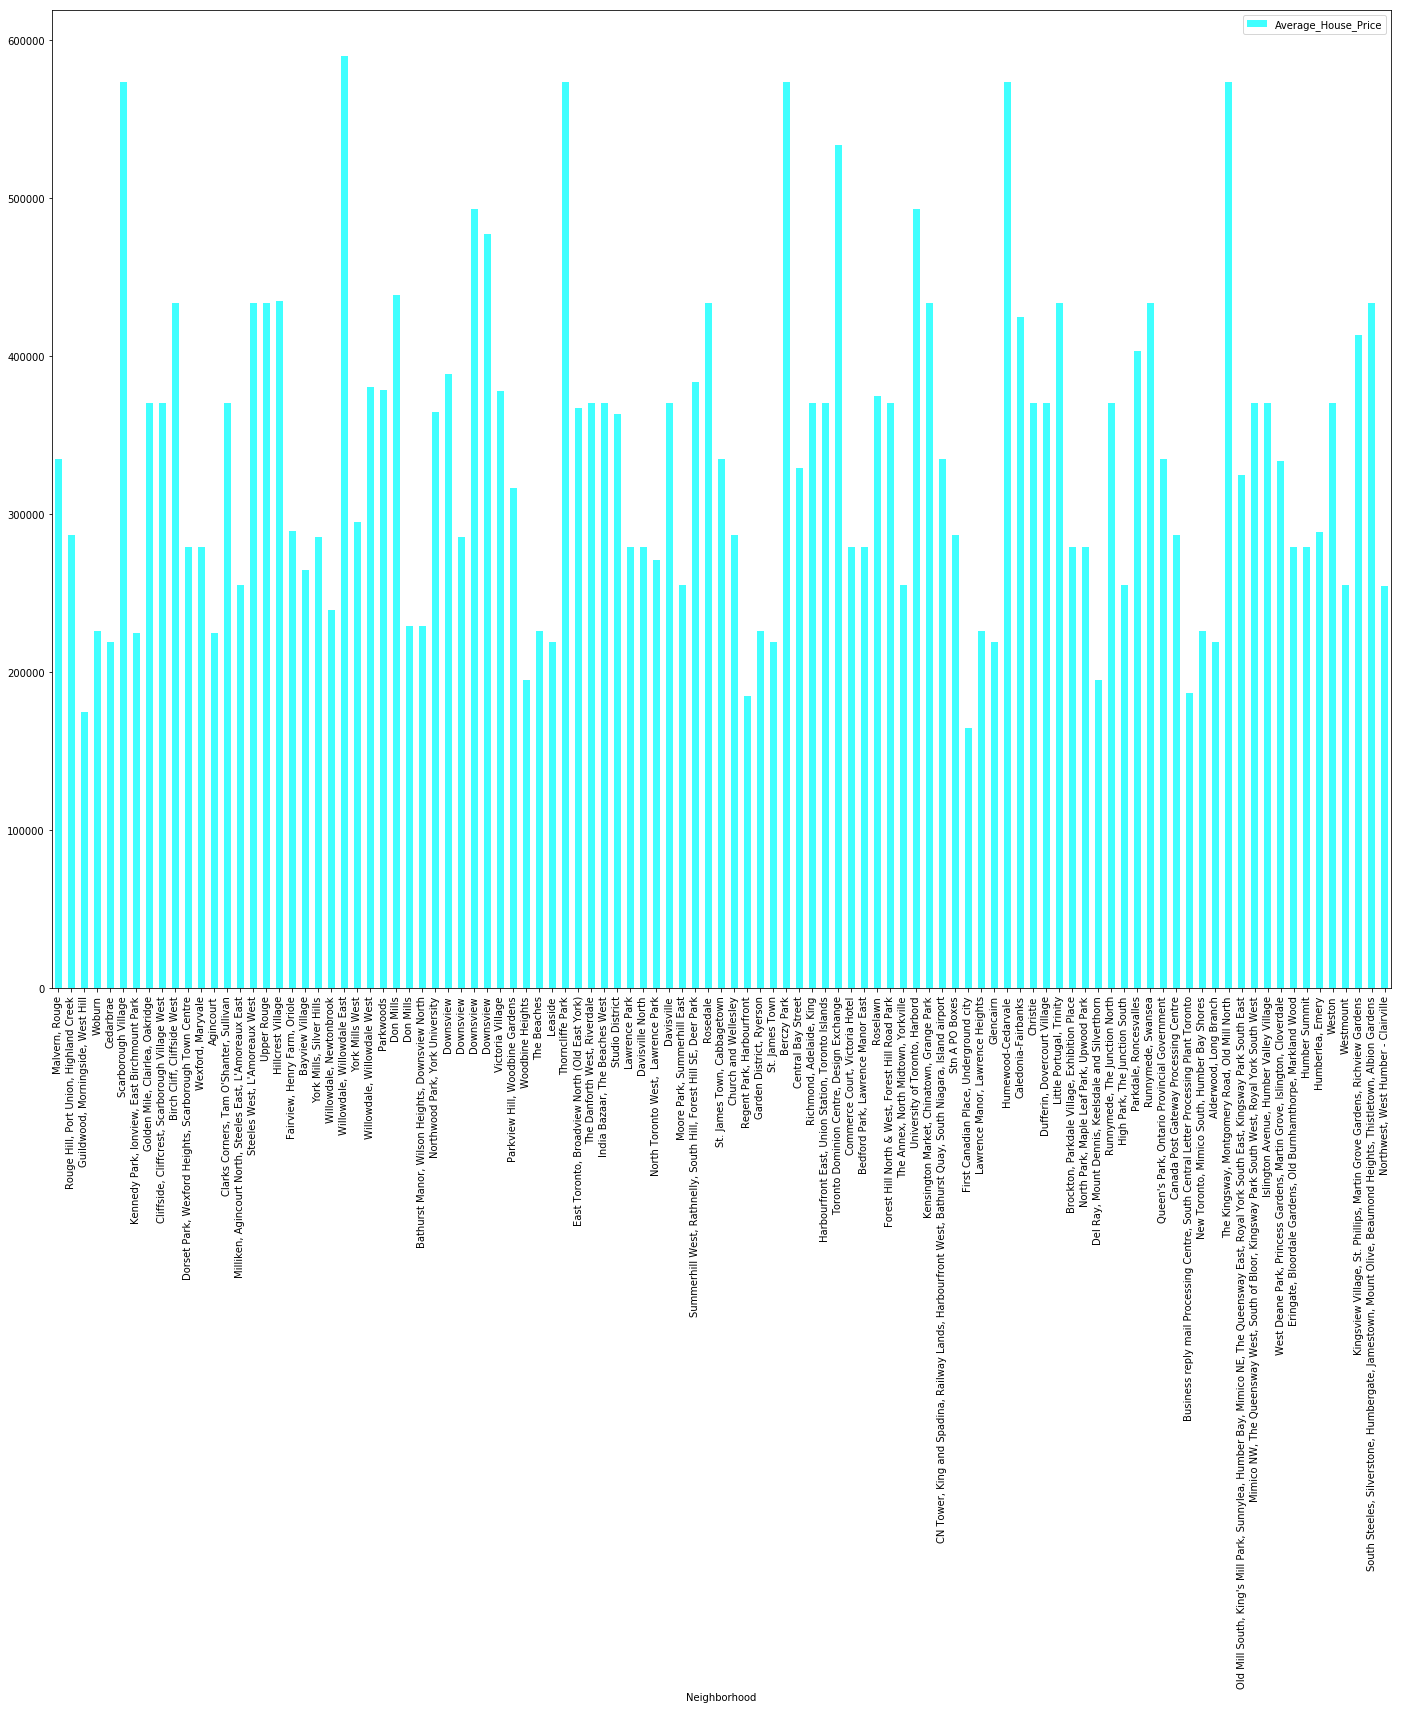

In [46]:
Downtown_Toronto_AvgHousePr=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_House_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})




Downtown_Toronto_AvgHousePr.set_index('Neighborhood',inplace=True,drop=True)
Downtown_Toronto_AvgHousePr.plot(kind='bar',figsize=(24,18),color='cyan',alpha=0.75)